## accountMetrics - Measuring Site Throughput, Part 3

One of the most commonly requested use cases for the [accountMetrics](https://api.catonetworks.com/documentation/#query-accountMetrics) API is for Cato customers to monitor throughput against licence, so we're going to combine the techniques in Part 1 and Part 2 with another query - the [licensingInfo](https://api.catonetworks.com/documentation/#definition-LicensingInfo) query.

We'll be graphing this week's activity:

![goal3.png](goal3.png)

This example requires the Matplotlib third party package to be installed.

### Initialising the connection to the API.
Firstly, let's import the libraries we need and set up the connection to the API. As usual, we assuming that the account ID and API key are preloaded as environment variables and we use our helper module to encapsulate the business of making an API call (see the [Getting Started](Getting%20Started.ipynb) notebook if any of this is unclear):

In [1]:
#
# Initialise the API connection
#
import datetime
import json
import os
import matplotlib.pyplot as plt
from cato import API
C = API(os.environ["CATO_API_KEY"])

### The licensingInfo query

The licensingInfo query is documented here: [https://api.catonetworks.com/documentation/#definition-LicensingInfo](https://api.catonetworks.com/documentation/#definition-LicensingInfo). This is the query we will send:

In [2]:
#
# Define the query
#
query = '''
query licensingInfo ($accountId:ID!) {
  licensing (accountId:$accountId) {
	licensingInfo {
	  licenses {
		sku
		description
		status
		startDate
		expirationDate
		plan
		lastUpdated
		... on SiteLicense {
		  siteLicenseGroup
		  regionality
		  siteLicenseType
		  total
		  site {id name}
		}
		... on PooledBandwidthLicense {
		  siteLicenseGroup
		  siteLicenseType
		  total
		  allocatedBandwidth
		  sites {
			site {id name}
			allocatedBandwidth
		  }
		}
	  }
	}
  }
}'''


#
# Variables
#
variables = {
    "accountId": os.environ["CATO_ACCOUNT_ID"]
}


#
# Send the query
#
success, result = C.send("licensingInfo", variables, query)
print(json.dumps(result, indent=2)[:1000],"...")

{
  "data": {
    "licensing": {
      "licensingInfo": {
        "licenses": [
          {
            "sku": "CATO_CASB",
            "description": null,
            "status": "ACTIVE",
            "startDate": null,
            "expirationDate": "2100-12-31T00:00:00.000Z",
            "plan": "COMMERCIAL",
            "lastUpdated": null
          },
          {
            "sku": "CATO_DATALAKE_6M",
            "description": null,
            "status": "ACTIVE",
            "startDate": null,
            "expirationDate": "2100-12-31T00:00:00.000Z",
            "plan": "COMMERCIAL",
            "lastUpdated": null
          },
          {
            "sku": "CATO_DEM",
            "description": null,
            "status": "ACTIVE",
            "startDate": null,
            "expirationDate": "2100-12-31T00:00:00.000Z",
            "plan": "COMMERCIAL",
            "lastUpdated": null
          },
          {
            "sku": "CATO_DLP",
            "description": null,
       

This gets us a list of licence SKUs assigned to the account. It is important to remember that a site could have multiple bandwidth licences (such as a China site with both global and regional licences) and there are multiple site bandwidth SKUs (four at time of writing). So in order to understand a site's total bandwidth allocation, we have to iterate through all SKUs looking for the site licence SKUs, then check those for our site ID. Pooled bandwidth SKUs have an array of sites; non-pooled SKUs will have a single site. SKUs are enumerated [here](https://api.catonetworks.com/documentation/#definition-LicenseSku); we are looking for:
```
CATO_PB
CATO_PB_SSE
CATO_SITE
CATO_SSE_SITE
```
and the ID of the site we're interested in is 119167.

In [3]:
#
# Licence total counter
#
licence_total = 0
site_id = "119167"

#
# Iterate over the SKUs
#
for license in result["data"]["licensing"]["licensingInfo"]["licenses"]:

    #
    # Pooled bandwidth SKUs
    #
    if license["sku"] in ["CATO_PB", "CATO_PB_SSE"]:
        for site in license["sites"]:
            if site["site"]["id"] == site_id:
                licence_total += site["allocatedBandwidth"]
    #
    # Non-pooled SKUs
    #
    if license["sku"] in ["CATO_SITE", "CATO_SSE_SITE"]:
        if license["site"] is not None and license["site"]["id"] == site_id:
            licence_total += license["total"]


#
# This is our total for the site
#
print(f'Total licence:{licence_total}')

Total licence:100


## Sending the accountMetrics query

As in the previous example we are going to graph both the **bytesUpstreamMax** and **bytesDownstreamMax** timeseries':

In [4]:
#
# Define the query
#
query = '''
query accountMetrics($buckets:Int $accountID:ID! $timeFrame:TimeFrame! $siteIDs:[ID!]) {
    accountMetrics(accountID:$accountID timeFrame:$timeFrame groupInterfaces:false groupDevices:true) {
        sites (siteIDs:$siteIDs) {
            id
            name
            interfaces {
                name
                timeseries (labels:[bytesDownstreamMax, bytesUpstreamMax] buckets:$buckets) {
                    label
                    units
                    data (perSecond:true)
                }
            }
        }
    }
}
'''


#
# Variables
#
variables = {
    "accountID": os.environ["CATO_ACCOUNT_ID"],
    "timeFrame": "utc.2025-02-{09/00:00:00--15/23:59:59}",
    "buckets": 168,
    "siteIDs": [119167],
}


#
# Send the query
#
success, result = C.send("accountMetrics", variables, query)

### Process the accountMetrics response

The difference now is that we will also add a timeseries to reflect the licence level. This will be a constant value.

In [5]:
#
# Construct the X and Y timeseries
#
y_up = []
y_down = []
x_up = []
x_down = []
for timeseries in result["data"]["accountMetrics"]["sites"][0]["interfaces"][0]["timeseries"]:
    for timestamp, value in timeseries["data"]:
    
        #
        # Convert the timestamp to a Python datetime
        #
        datetime_timestamp = datetime.datetime.fromtimestamp(timestamp/1000)
    
        #
        # Convert the value to megabits per second and add to x
        #
        bps = value*8/1_000_000
        if timeseries["label"] == "bytesDownstreamMax":
            x_down.append(datetime_timestamp)
            y_down.append(bps)
        elif timeseries["label"] == "bytesUpstreamMax":
            x_up.append(datetime_timestamp)
            y_up.append(bps)


#
# We assume that the up labels will also suffice for down
#
x_labels = [X.strftime("%d/%H:%M") for X in x_up]


#
# Construct a licence timeseries
#
y_licence = [licence_total for X in x_labels]

## Create the graph

We plot the up values in green, the down values in blue, and the licence in red:

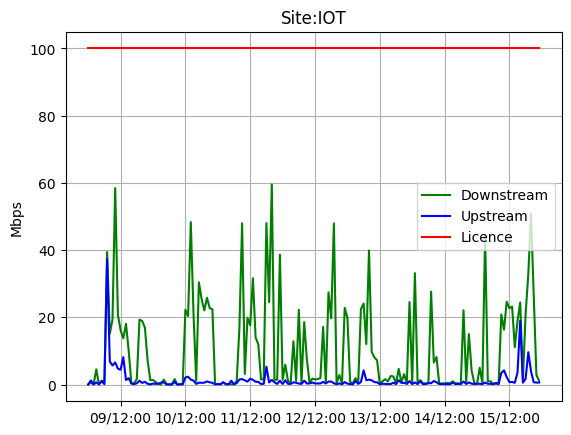

In [6]:
#
# We only want several specific X-labels
#
xtick_locs = []
xtick_labels = []
for i,label in zip(x_up, x_labels):
    if label[-5:] in ["12:00"]:
        xtick_locs.append(i)
        xtick_labels.append(label)

#
# Create and show the graph
#
plt.close("all")
plt.title(f"Site:{result["data"]["accountMetrics"]["sites"][0]["name"]}")
plt.ylabel(f"Mbps")
plt.xticks(xtick_locs, xtick_labels)
plt.grid()
plt.plot(x_down, y_down, label="Downstream", color="green")
plt.plot(x_up, y_up, label="Upstream", color="blue")
plt.plot(x_up, y_licence, label="Licence", color="red")
plt.legend()
plt.show()